In [1]:
# This cell imports %%execwritefile command (executes cell and writes it into file). 
# All cells that start with %%execwritefile should be in td_autograde.py file after running all cells.
from custommagics import CustomMagics
get_ipython().register_magics(CustomMagics)

In [17]:
import numpy as np
import scipy.stats
from collections import defaultdict
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys

import random
import time
import copy
assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

In [4]:
import gym
from gym import spaces

class CustomEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(CustomEnv, self).__init__()

        self.nS = 4
        self.nA = 8

        self.action_space = spaces.Discrete(8)
        # Example for using image as input:
        self.observation_space = spaces.Discrete(4)
        self.reward_range = [-0.1, 1.0]
        P = {}
        P[0] = {}
        P[1] = {}
        P[2] = {}
        P[0][0] = [(1.0, 1, 0, True)]
        P[0][1] = [(1.0, 2, 0, False)]
        P[2][0] = [(1.0, 3, 'random', True)]
        P[2][1] = [(1.0, 3, 'random', True)]
        P[2][2] = [(1.0, 3, 'random', True)]
        P[2][3] = [(1.0, 3, 'random', True)]
        P[2][4] = [(1.0, 3, 'random', True)]
        P[2][5] = [(1.0, 3, 'random', True)]
        P[2][6] = [(1.0, 3, 'random', True)]
        P[2][7] = [(1.0, 3, 'random', True)]
        self.P = P



    def step(self, a):
        # Execute one time step within the environment
        transitions = self.P[self.s][a]
        #     i = categorical_sample([t[0] for t in transitions], self.np_random)
        i = np.random.choice(len(transitions), p=[t[0] for t in transitions])
        p, s, r, d = transitions[i]
        if r == 'random':
            r = np.random.normal(*self.reward_range)
        self.s = s
        self.lastaction = a
        return (int(s), r, d, {"prob": p})

    def reset(self):
        self.s = 0
        self.lastaction = None
        return self.s
        
    def create_Q(self):
        Q = np.array([np.zeros(2), np.zeros(1), np.zeros(8), np.zeros(1)], dtype=object)
        return Q
    
#   def render(self, mode='human', close=False):
#     # Render the environment to the screen
#     ...
    

env = CustomEnv()

In [5]:
class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
        if np.random.random() < self.epsilon:
            return np.random.choice(len(self.Q[obs]))
        else:
            return np.random.choice(np.flatnonzero(self.Q[obs] == self.Q[obs].max()))

In [6]:
def running_mean(vals, n=1):
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n

In [68]:
def q_learning(env, policy, Q, num_episodes, discount_factor=1.0, alpha=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        policy: A behavior policy which allows us to sample actions with its sample_action method.
        Q: Q value function
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keeps track of useful statistics
    stats = []
    for i_episode in range(num_episodes):
        i = 0 # episode length
        R = 0 # episode return
        
        state = env.reset()
        while True:
            i += 1 # update episode length
    
            a = policy.sample_action(state)
            
            (next_state, reward, done, _) = env.step(a)
            max_a = np.max(Q[next_state])
            Q[state][a] = Q[state][a] + alpha*(reward + discount_factor*max_a - Q[state][a])
            R += reward # update episode return
            
            state = next_state
            policy.Q = copy.deepcopy(Q)
            if done:
                break
        if next_state == 1:
            choice = 1
        else:
            choice = 0
        stats.append((i, R, choice))
    episode_lengths, episode_returns, choices = zip(*stats)
    return Q, (episode_lengths, episode_returns, choices)

In [69]:
def deep_plus(Q1, Q2):
    Q = []
    for i in range(4):
        Q.append(Q1[i]+Q2[i])
    return np.array(Q)

def double_q_learning(env, policy, Q, num_episodes, discount_factor=1.0, alpha=0.1):
    # Keeps track of useful statistics
    stats = []
    Q1 = copy.deepcopy(Q)
    Q2 = copy.deepcopy(Q)
    for i_episode in range(num_episodes):
        i = 0 # episode length
        R = 0 # episode return
        
        state = env.reset()
        while True:
            i += 1 # update episode length
                
            a = policy.sample_action(state)
            (next_state, reward, done, _) = env.step(a)
            if np.random.choice([True, False]):
                argmax_a = np.argmax(Q1[next_state])
                Q1[state][a] = Q1[state][a] + alpha*(reward + discount_factor*Q2[next_state][argmax_a] - Q1[state][a])
            else:
                argmax_a = np.argmax(Q2[next_state])
                Q2[state][a] = Q2[state][a] + alpha*(reward + discount_factor*Q1[next_state][argmax_a] - Q2[state][a])
            
            R += reward # update episode return
            
            state = next_state
            
            policy.Q = deep_plus(Q1, Q2)
            if done:
                break
        
        Q = deep_plus(Q1, Q2)
        if next_state == 1:
            choice = 1
        else:
            choice = 0
        stats.append((i, R, choice))
    episode_lengths, episode_returns, choices = zip(*stats)
    return Q, (episode_lengths, episode_returns, choices)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/var/folders/4r/8mllzytn5zd1z5pl5rrtjyn80000gn/T/ipykernel_67817/1155787334.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(Q)
100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 86.53it/s]


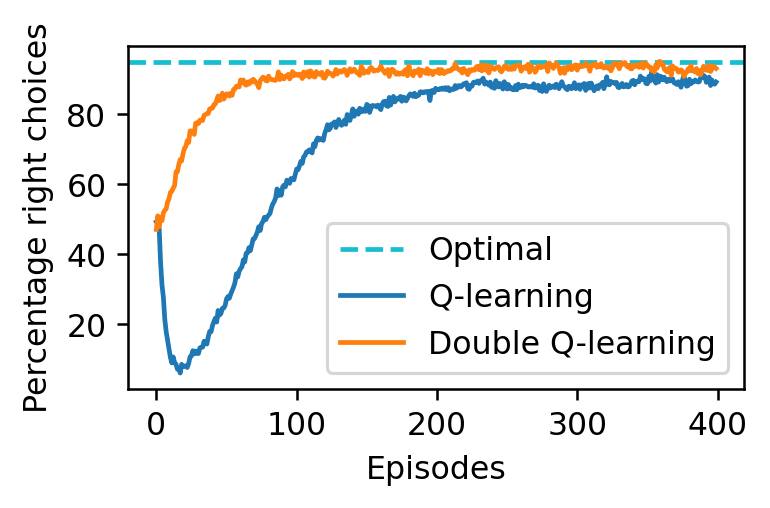

In [70]:
def mean_multiple_runs_both_algorithms(n_runs = 100, n_episodes = 400):
    single_choices_results = np.zeros((n_runs, n_episodes))
    np.random.seed(42)
    for i in tqdm(range(n_runs)):
        Q = env.create_Q()
        policy = EpsilonGreedyPolicy(Q, epsilon=0.1)
        Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning, episode_choices_q_learning) = q_learning(env, policy, Q, n_episodes)
        single_choices_results[i] = episode_choices_q_learning        
    double_choices_results = np.zeros((n_runs, n_episodes))
    for i in tqdm(range(n_runs)):
        Q = env.create_Q()
        policy = EpsilonGreedyPolicy(Q, epsilon=0.1)
        Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning, episode_choices_q_learning) = double_q_learning(env, policy, Q, n_episodes)
        double_choices_results[i] = episode_choices_q_learning        
    return np.mean(single_choices_results, axis=0)*100, np.mean(double_choices_results, axis=0)*100

def plot_both(mean_single, mean_double):
    plt.figure(figsize=[3.5,2],dpi=227)

    plt.axhline(y=95, color='tab:cyan', linestyle='--', label='Optimal')
    plt.plot(mean_single, label='Q-learning')
    plt.plot(mean_double, label='Double Q-learning')
    plt.xlabel('Episodes')
    plt.ylabel('Percentage right choices')
    plt.legend()
    plt.show()
    
plot_both(*mean_multiple_runs_both_algorithms(n_runs=1000))

/var/folders/4r/8mllzytn5zd1z5pl5rrtjyn80000gn/T/ipykernel_59403/231040337.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(Q)


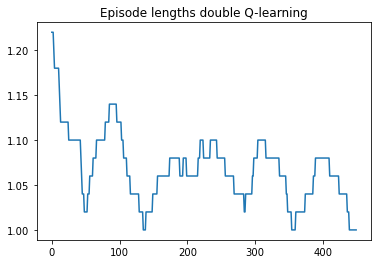

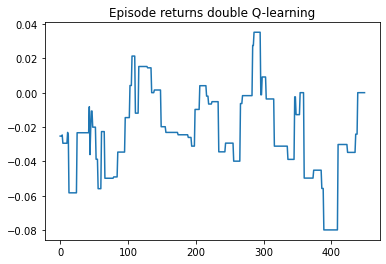

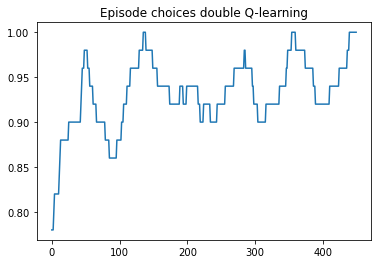

  0%|                                                   | 0/500 [00:00<?, ?it/s]/var/folders/4r/8mllzytn5zd1z5pl5rrtjyn80000gn/T/ipykernel_59403/231040337.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(Q)
100%|████████████████████████████████████████| 500/500 [00:01<00:00, 329.00it/s]

100


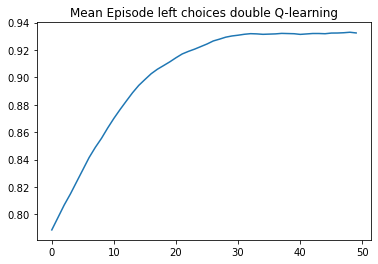

[array([ 0.        , -0.05392607]) array([0.])
 array([-0.36426156, -0.39895408, -0.48124368, -0.32152841,  0.31433512,
        -0.76831304, -0.80165236, -1.27775107])
 array([0.])]


In [20]:
def multiple_runs(n_runs = 500, n_episodes=100):
    choices_results = np.zeros((n_runs, n_episodes))
    for i in tqdm(range(n_runs)):
        Q = env.create_Q()
        policy = EpsilonGreedyPolicy(Q, epsilon=0.1)
        Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning, episode_choices_q_learning) = double_q_learning(env, policy, Q, n_episodes)
        choices_results[i] = episode_choices_q_learning
    return np.mean(choices_results, axis=0), np.std(choices_results, axis=0)

Q = env.create_Q()
policy = EpsilonGreedyPolicy(copy.deepcopy(Q), epsilon=0.1)
Q_double_q_learning, (episode_lengths_double_q_learning, episode_returns_double_q_learning, episode_choices_double_q_learning) = double_q_learning(env, policy, Q, 500)

n = 50
# We will help you with plotting this time
plt.plot(running_mean(episode_lengths_double_q_learning,n))
plt.title('Episode lengths double Q-learning')
plt.show()
plt.plot(running_mean(episode_returns_double_q_learning,n))
plt.title('Episode returns double Q-learning')
plt.show()
plt.plot(running_mean(episode_choices_double_q_learning,n))
plt.title('Episode choices double Q-learning')
plt.show()

mean_choices = multiple_runs()
print(len(mean_choices))
plt.plot(running_mean(mean_choices,n))
plt.title('Mean Episode left choices double Q-learning')
plt.show()
print(Q_q_learning)



NameError: name 'episode_returns_double_q_learning' is not defined

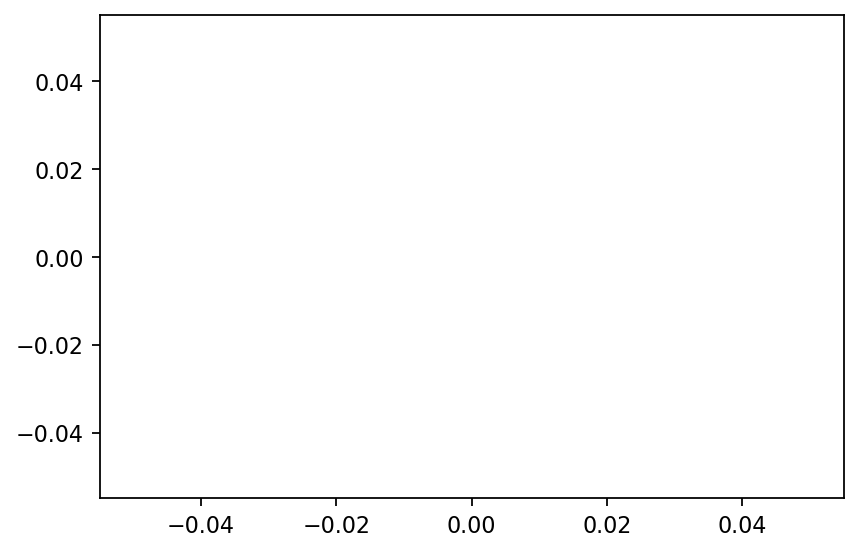

In [52]:
n = 100
plt.figure(dpi=160)
plt.plot(running_mean(episode_returns_q_learning, n), label='Q-Learning')
plt.plot(running_mean(episode_returns_double_q_learning, n), label='Double Q-Learning')
# plt.plot(running_mean(episode_returns_sarsa, n), label='Sarsa')

plt.title('Episode returns TD - Windy Gridworld')
# plt.legend(['Q-Learning', 'Double Q-learning', 'Sarsa'])
plt.legend()
plt.gca().set_ylim([-50, 0])
plt.show()